In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

## Create DataFrame

In [2]:
df = pd.read_csv("kc_house_data_train.csv")
df.drop("Unnamed: 0", axis=1, inplace= True)
print(df.shape)
df.head(10)

(17290, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,...,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,...,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,...,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,...,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,...,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050
5,1761300310,20140827T000000,211000.0,4,2.00,1710,8288,1.5,0,0,...,7,1710,0,1970,0,98031,47.3947,-122.174,1710,7200
6,7732410120,20140819T000000,790000.0,4,2.50,2690,8036,2.0,0,0,...,9,2690,0,1987,0,98007,47.6596,-122.144,2420,8087
7,7010701383,20141017T000000,680000.0,3,2.50,1800,4400,1.0,0,0,...,7,1350,450,1970,0,98199,47.6599,-122.396,1920,4400
8,291310170,20140804T000000,384500.0,3,2.50,1600,2610,2.0,0,0,...,8,1600,0,2005,0,98027,47.5344,-122.068,1445,1288
9,4232901990,20140516T000000,605000.0,2,1.00,910,3600,1.0,0,0,...,7,910,0,1909,0,98119,47.6341,-122.361,1720,3600


## Preliminary Metrics Exploration

In [3]:
#get all column names and data types to see if there is anything I need to change
column_names = df.columns
print(column_names)
df.dtypes

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [4]:
#transform date into more readable format
df['date'] = pd.to_datetime(df['date'])
df['date']

0       2014-10-06
1       2014-08-21
2       2014-08-15
3       2015-03-31
4       2014-07-14
           ...    
17285   2015-03-03
17286   2014-05-20
17287   2014-05-14
17288   2014-12-04
17289   2015-01-16
Name: date, Length: 17290, dtype: datetime64[ns]

### Investigating Built Year & Renovation Years

In [5]:
## years renovated distribution

df.yr_renovated.value_counts()

0       16564
2014       71
2007       32
2005       32
2000       31
        ...  
1934        1
1959        1
1944        1
1951        1
1948        1
Name: yr_renovated, Length: 69, dtype: int64

In [6]:
## Feature 1 - How many years since the last renovation
df.loc[df['yr_built'] != 0, 'built_years'] = 2021-df['yr_built']
df.built_years

0        35
1        44
2        24
3        31
4        17
         ..
17285    63
17286    73
17287    68
17288    50
17289    69
Name: built_years, Length: 17290, dtype: int64

In [7]:
## Feature 2 - How many years since house built
df.loc[df['yr_renovated'] != 0, 'renovated_years'] = 2021-df['yr_renovated']
df['renovated_years'] = df['renovated_years'].fillna(0)

In [8]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'built_years',
       'renovated_years'],
      dtype='object')

In [9]:
df.loc[df['yr_renovated'] != 0, 'years_to_renovation'] = df['yr_renovated']-df['yr_built']
df['years_to_renovation'] = df['years_to_renovation'].fillna(0)

In [10]:
df.loc[df.years_to_renovation != 0][['yr_built', 'yr_renovated', 'years_to_renovation']]

,yr_built,yr_renovated,years_to_renovation
11,1963,1998,35.0
33,1918,1983,65.0
67,1974,1989,15.0
186,1950,1985,35.0
227,1950,1985,35.0
...,...,...,...
17229,1941,1998,57.0
17235,1968,2005,37.0
17239,1958,1992,34.0
17248,1951,1994,43.0


### Investigating Bathrooms

In [11]:
## What is the distribution of bathroom count
df.bathrooms.value_counts().sort_index()

0.00       8
0.50       3
0.75      52
1.00    3100
1.25       6
1.50    1168
1.75    2431
2.00    1549
2.25    1666
2.50    4322
2.75     896
3.00     592
3.25     455
3.50     591
3.75     135
4.00     107
4.25      64
4.50      76
4.75      16
5.00      17
5.25      11
5.50       7
5.75       3
6.00       6
6.25       2
6.50       1
6.75       2
7.50       1
7.75       1
8.00       2
Name: bathrooms, dtype: int64

In [12]:
df.groupby('bathrooms')['price'].mean()

## Weird thing - 1.25 bathrooms costs 200K more than 1.5 baths to 2.5 baths. 

bathrooms
0.00    5.077062e+05
0.50    2.255000e+05
0.75    2.766520e+05
1.00    3.463276e+05
1.25    6.010000e+05
1.50    4.073672e+05
1.75    4.582803e+05
2.00    4.557473e+05
2.25    5.372734e+05
2.50    5.566379e+05
2.75    6.545027e+05
3.00    7.149029e+05
3.25    9.656770e+05
3.50    9.289996e+05
3.75    1.198263e+06
4.00    1.309828e+06
4.25    1.532047e+06
4.50    1.328587e+06
4.75    1.817828e+06
5.00    1.749518e+06
5.25    1.866118e+06
5.50    2.803286e+06
5.75    3.143333e+06
6.00    2.946833e+06
6.25    3.094000e+06
6.50    2.238890e+06
6.75    2.734000e+06
7.50    4.500000e+05
7.75    6.885000e+06
8.00    4.990000e+06
Name: price, dtype: float64

In [13]:
df['floors_to_bathroom'] = df.bathrooms/df.floors

In [14]:
df[['bathrooms', 'floors', 'floors_to_bathroom']]

,bathrooms,floors,floors_to_bathroom
0,2.25,2.0,1.125
1,3.00,1.0,3.000
2,2.50,2.0,1.250
3,3.50,2.0,1.750
4,2.50,2.0,1.250
...,...,...,...
17285,2.50,1.0,2.500
17286,1.75,2.0,0.875
17287,1.00,1.0,1.000
17288,1.50,1.5,1.000


### Investigating Bedrooms

In [15]:
df.bedrooms.value_counts()

3     7864
4     5488
2     2204
5     1283
6      229
1      160
7       30
0       12
8       10
9        5
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [16]:
df.groupby('bedrooms')['price'].mean()

bedrooms
0     4.319667e+05
1     3.265255e+05
2     4.006608e+05
3     4.654743e+05
4     6.377381e+05
5     7.847411e+05
6     8.377285e+05
7     9.861672e+05
8     1.255600e+06
9     8.167998e+05
10    8.193333e+05
11    5.200000e+05
33    6.400000e+05
Name: price, dtype: float64

In [17]:
df = df[df.bedrooms <= 8]

### Investigating Sale Months & Seasons

I wanted to see if there was a correlation in month sold and prices

In [18]:
df['month_sold'] = df['date'].dt.month
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,built_years,renovated_years,years_to_renovation,floors_to_bathroom,month_sold
0,2591820310,2014-10-06,365000.0,4,2.25,2070,8893,2.0,0,0,...,98058,47.4388,-122.162,2390,7700,35,0.0,0.0,1.125,10
1,7974200820,2014-08-21,865000.0,5,3.00,2900,6730,1.0,0,0,...,98115,47.6784,-122.285,2370,6283,44,0.0,0.0,3.000,8
2,7701450110,2014-08-15,1038000.0,4,2.50,3770,10893,2.0,0,2,...,98006,47.5646,-122.129,3710,9685,24,0.0,0.0,1.250,8
3,9522300010,2015-03-31,1490000.0,3,3.50,4560,14608,2.0,0,2,...,98034,47.6995,-122.228,4050,14226,31,0.0,0.0,1.750,3
4,9510861140,2014-07-14,711000.0,3,2.50,2550,5376,2.0,0,0,...,98052,47.6647,-122.083,2250,4050,17,0.0,0.0,1.250,7


In [19]:
df.groupby(df.month_sold)['price'].mean()

month_sold
1     515699.571429
2     508686.988889
3     537030.673360
4     561916.902993
5     553500.663207
6     561705.793379
7     545195.457694
8     539441.579589
9     526573.607349
10    540782.648123
11    528512.076256
12    526318.284003
Name: price, dtype: float64

In [20]:
## Feature 3 - Adding a season column

conditions = [
    df.month_sold.isin([12,1,2]),
    df.month_sold.isin([3,4,5]),
    df.month_sold.isin([6,7,8]),
    df.month_sold.isin([9,10,11])
]

choices = [
    1,
    2,
    3,
    4
]

df['seasons'] = np.select(conditions, choices, default="NaN")

## Legend: 1=Winter, 2=Spring, 3=Summer, 4=Fall

In [21]:
df['seasons']

0        4
1        3
2        3
3        2
4        3
        ..
17285    2
17286    2
17287    2
17288    1
17289    1
Name: seasons, Length: 17280, dtype: object

In [22]:
price_by_season = df.groupby('seasons')['price'].mean()

In [23]:
num_sold_by_seasons = price_by_season = df.seasons.value_counts().sort_index()

In [24]:
num_sold_by_seasons

1    2950
2    5225
3    5071
4    4034
Name: seasons, dtype: int64

### Investigating Zip Codes

In [25]:
avg_price_zip = df.groupby('zipcode')['price'].mean()

In [26]:
avg_price_zip.describe()

count    7.000000e+01
mean     5.627793e+05
std      3.080248e+05
min      2.322865e+05
25%      3.547935e+05
50%      4.950228e+05
75%      6.447316e+05
max      2.202790e+06
Name: price, dtype: float64

### Investigating Sqft_Living

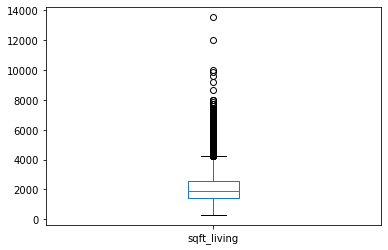

In [27]:
df.sqft_living.plot(kind='box');

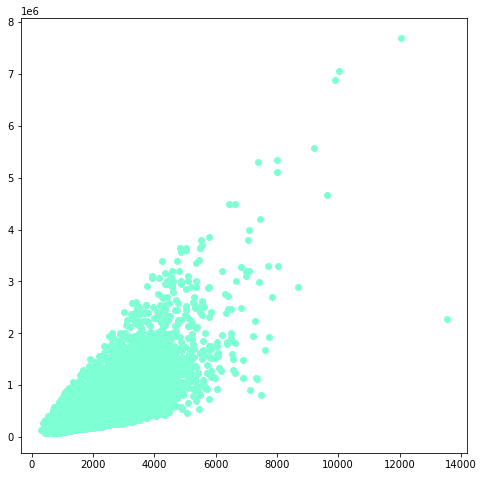

In [28]:
fig,ax = plt.subplots(figsize=(8,8))
plt.scatter(df['sqft_living'], df['price'], color='aquamarine');

In [29]:
df['yard'] = df.sqft_lot/(df.sqft_living/df.floors)

### Investigating View Data

In [30]:
df.view.value_counts().sort_index()

0    15562
1      264
2      774
3      410
4      270
Name: view, dtype: int64

## Cleaning Data

### Dummy Data for Zip Code

In [31]:
zip_dummy = pd.get_dummies(df['zipcode'])
df = pd.concat([df, zip_dummy], axis=1)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,2591820310,2014-10-06,365000.0,4,2.25,2070,8893,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7974200820,2014-08-21,865000.0,5,3.00,2900,6730,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7701450110,2014-08-15,1038000.0,4,2.50,3770,10893,2.0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,9522300010,2015-03-31,1490000.0,3,3.50,4560,14608,2.0,0,2,...,0,0,0,0,0,0,0,0,0,0
4,9510861140,2014-07-14,711000.0,3,2.50,2550,5376,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Grade Dummy Data

In [32]:
view_dummy = pd.get_dummies(df['grade']).rename(columns=lambda x: 'grade_' + str(x))
df = pd.concat([df, view_dummy], axis=1)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
0,2591820310,2014-10-06,365000.0,4,2.25,2070,8893,2.0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,7974200820,2014-08-21,865000.0,5,3.00,2900,6730,1.0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,7701450110,2014-08-15,1038000.0,4,2.50,3770,10893,2.0,0,2,...,0,0,0,0,0,0,0,1,0,0
3,9522300010,2015-03-31,1490000.0,3,3.50,4560,14608,2.0,0,2,...,0,0,0,0,0,0,0,0,1,0
4,9510861140,2014-07-14,711000.0,3,2.50,2550,5376,2.0,0,0,...,0,0,0,0,0,1,0,0,0,0


### Month Sold Dummy Data

In [33]:
month_dummy = pd.get_dummies(df['month_sold']).rename(columns=lambda x: 'month_' + str(x))
df = pd.concat([df, month_dummy], axis=1)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2591820310,2014-10-06,365000.0,4,2.25,2070,8893,2.0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,7974200820,2014-08-21,865000.0,5,3.00,2900,6730,1.0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,7701450110,2014-08-15,1038000.0,4,2.50,3770,10893,2.0,0,2,...,0,0,0,0,0,1,0,0,0,0
3,9522300010,2015-03-31,1490000.0,3,3.50,4560,14608,2.0,0,2,...,1,0,0,0,0,0,0,0,0,0
4,9510861140,2014-07-14,711000.0,3,2.50,2550,5376,2.0,0,0,...,0,0,0,0,1,0,0,0,0,0


### Condition Dummy Data

In [34]:
condition_dummy = pd.get_dummies(df['condition']).rename(columns=lambda x: 'condition_' + str(x))
df = pd.concat([df, condition_dummy], axis=1)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,month_8,month_9,month_10,month_11,month_12,condition_1,condition_2,condition_3,condition_4,condition_5
0,2591820310,2014-10-06,365000.0,4,2.25,2070,8893,2.0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,7974200820,2014-08-21,865000.0,5,3.00,2900,6730,1.0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,7701450110,2014-08-15,1038000.0,4,2.50,3770,10893,2.0,0,2,...,1,0,0,0,0,0,0,1,0,0
3,9522300010,2015-03-31,1490000.0,3,3.50,4560,14608,2.0,0,2,...,0,0,0,0,0,0,0,1,0,0
4,9510861140,2014-07-14,711000.0,3,2.50,2550,5376,2.0,0,0,...,0,0,0,0,0,0,0,1,0,0


### View Dummy Data

In [35]:
view_dummy = pd.get_dummies(df['view']).rename(columns=lambda x: 'view_' + str(x))
df = pd.concat([df, view_dummy], axis=1)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,condition_1,condition_2,condition_3,condition_4,condition_5,view_0,view_1,view_2,view_3,view_4
0,2591820310,2014-10-06,365000.0,4,2.25,2070,8893,2.0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,7974200820,2014-08-21,865000.0,5,3.00,2900,6730,1.0,0,0,...,0,0,0,0,1,1,0,0,0,0
2,7701450110,2014-08-15,1038000.0,4,2.50,3770,10893,2.0,0,2,...,0,0,1,0,0,0,0,1,0,0
3,9522300010,2015-03-31,1490000.0,3,3.50,4560,14608,2.0,0,2,...,0,0,1,0,0,0,0,1,0,0
4,9510861140,2014-07-14,711000.0,3,2.50,2550,5376,2.0,0,0,...,0,0,1,0,0,1,0,0,0,0


### Bathroom Outliers

In [36]:
no_bath_houses = df[df.bathrooms==0].index
df.drop(no_bath_houses, inplace=True)

In [37]:
df[df.bathrooms==0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,condition_1,condition_2,condition_3,condition_4,condition_5,view_0,view_1,view_2,view_3,view_4


Dropped data for very expensive 1.25 bath house

In [38]:
df.drop(15263, axis=0, inplace=True)

Rechecking mean

In [39]:
df.groupby('bathrooms')['price'].mean()

bathrooms
0.50    2.255000e+05
0.75    2.766520e+05
1.00    3.463276e+05
1.25    4.718000e+05
1.50    4.073672e+05
1.75    4.582055e+05
2.00    4.556218e+05
2.25    5.372734e+05
2.50    5.566379e+05
2.75    6.545027e+05
3.00    7.149804e+05
3.25    9.656770e+05
3.50    9.289996e+05
3.75    1.198263e+06
4.00    1.308977e+06
4.25    1.532047e+06
4.50    1.338302e+06
4.75    1.817828e+06
5.00    1.749518e+06
5.25    1.937930e+06
5.50    2.803286e+06
5.75    3.143333e+06
6.00    2.946833e+06
6.25    3.094000e+06
6.50    2.238890e+06
6.75    2.734000e+06
7.75    6.885000e+06
8.00    4.990000e+06
Name: price, dtype: float64

### Bedroom Outliers

In [40]:
df.bedrooms.value_counts().sort_index()

0       6
1     157
2    2204
3    7864
4    5488
5    1283
6     229
7      30
8      10
Name: bedrooms, dtype: int64

In [41]:
bedroom_outliers = df.loc[((df.bedrooms==0) | (df.bedrooms==33)) & (df.sqft_living >= 700)].index

In [42]:
df.drop(bedroom_outliers, axis=0, inplace=True)

In [43]:
df.bedrooms.value_counts().sort_index()

0       2
1     157
2    2204
3    7864
4    5488
5    1283
6     229
7      30
8      10
Name: bedrooms, dtype: int64

### Sqft to Bedrooms

In [44]:
df.loc[df['bedrooms'] != 0, 'sqft_to_bed'] = df['sqft_living']/df['bedrooms']
df.loc[df['bedrooms'] == 0, 'sqft_to_bed'] = df['sqft_living']/1

In [45]:
df.groupby('zipcode')['sqft_to_bed'].mean()

zipcode
98001    567.878521
98002    495.846072
98003    577.435714
98004    768.153249
98005    701.620238
            ...    
98177    670.704893
98178    529.923256
98188    530.927217
98198    560.608409
98199    676.906275
Name: sqft_to_bed, Length: 70, dtype: float64

### Renovations

In [46]:
df.loc[df['yr_renovated'] != 0, 'renovated'] = 1
df.loc[df['yr_renovated'] == 0, 'renovated'] = 0

## Stats Tests

Test 1: Is there a significant difference between sold prices during different seasons? I chose an ANOVA test for this

H0 = H1=H2=H3=H4\
HA = H0 != True

In [47]:
print(stats.f_oneway(df.loc[df.seasons=="1"]['price'],df.loc[df.seasons=="2"]['price'],df.loc[df.seasons=="3"]['price'],df.loc[df.seasons=="4"]['price']))
print(f'We reject our null hypothesis because the pvalue is lower than our alpha. The prices between different seasons are not the same')

F_onewayResult(statistic=6.601205176765286, pvalue=0.00018737552985759415)
We reject our null hypothesis because the pvalue is lower than our alpha. The prices between different seasons are not the same


Test 2: Is there a siginifcant difference between price of houses with a waterfront and without? I chose a one sided t-test for this

H0: P1=P2\
HA: P1 != P2

In [48]:
print(df.loc[df.waterfront==0]['price'].var())
print(df.loc[df.waterfront==1]['price'].var())

119375476503.04938
1310845285318.3284


In [49]:
stats.ttest_ind(df.loc[df.waterfront==0]['price'],df.loc[df.waterfront==1]['price'], axis=0, equal_var=False, nan_policy='propagate')

Ttest_indResult(statistic=-11.857364548768071, pvalue=1.0104054622696716e-22)

In [50]:
f'We reject the null hypothesis that there is no difference between the two groups'

'We reject the null hypothesis that there is no difference between the two groups'

Test 3: Is there a siginifcant difference between price of houses that have been renovated vs not? I chose a one sided t-test for this

H0: P1=P2\
HA: P1 != P2

In [51]:
print(df.loc[df.renovated==0]['price'].var())
print(df.loc[df.renovated==1]['price'].var())

126496912132.08037
387212820819.91327


In [52]:
stats.ttest_ind(df.loc[df.renovated==1]['price'],df.loc[df.renovated==0]['price'], axis=0, equal_var=False, nan_policy='propagate')

Ttest_indResult(statistic=9.407778870802797, pvalue=6.133955896922142e-20)

In [53]:
f'We reject the null hypothesis that there is no difference between the two groups'

'We reject the null hypothesis that there is no difference between the two groups'

In [54]:
df.groupby('renovated')['price'].mean()

renovated
0.0    531443.599383
1.0    750411.277241
Name: price, dtype: float64

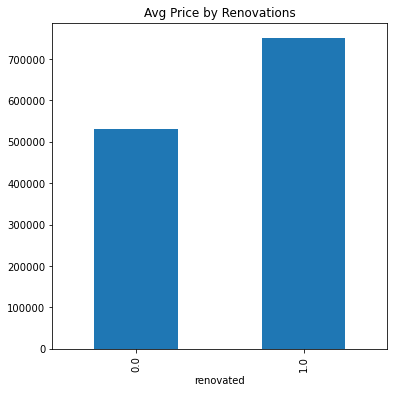

In [55]:
renovated_price = df.groupby('renovated')['price'].mean().plot(kind='bar', title = 'Avg Price by Renovations', figsize=(6,6))
plt.savefig('avg_price_by_renovations')

In [56]:
df['renovated'].value_counts()

0.0    16542
1.0      725
Name: renovated, dtype: int64

## Correlation between all columns

In [57]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,condition_3,condition_4,condition_5,view_0,view_1,view_2,view_3,view_4,sqft_to_bed,renovated
id,1.000000,-0.015766,-0.000629,0.004223,-0.014230,-0.129915,0.016950,0.000945,0.013066,-0.014306,...,0.021663,-0.020764,-0.001383,-0.013246,0.005553,0.013482,-0.012431,0.019274,-0.013258,-0.019357
price,-0.015766,1.000000,0.316758,0.526282,0.703634,0.086950,0.257083,0.275767,0.395357,0.035881,...,0.006547,-0.031761,0.058647,-0.354343,0.091174,0.138173,0.176879,0.317419,0.579165,0.117648
bedrooms,-0.000629,0.316758,1.000000,0.522679,0.592764,0.031697,0.182745,-0.007040,0.085333,0.020908,...,0.008957,-0.007342,0.018110,-0.084523,0.022279,0.045116,0.053566,0.040917,-0.021842,0.012174
bathrooms,0.004223,0.526282,0.522679,1.000000,0.756823,0.086116,0.500942,0.067097,0.190379,-0.123830,...,0.188943,-0.165142,-0.033618,-0.178057,0.037001,0.083424,0.114378,0.113538,0.522436,0.047505
sqft_living,-0.014230,0.703634,0.592764,0.756823,1.000000,0.167247,0.357021,0.110555,0.283927,-0.061582,...,0.103885,-0.084142,-0.020763,-0.266746,0.065373,0.123624,0.157494,0.179532,0.754782,0.051123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
view_2,0.013482,0.138173,0.045116,0.083424,0.123624,0.033970,0.003882,0.002763,0.491906,0.028574,...,-0.019364,0.008464,0.024842,-0.651469,-0.026957,1.000000,-0.033739,-0.027215,0.122626,0.023174
view_3,-0.012431,0.176879,0.053566,0.114378,0.157494,0.071643,0.019234,0.054652,0.555894,0.017750,...,-0.017214,0.016332,0.006433,-0.469638,-0.019433,-0.033739,1.000000,-0.019619,0.150434,0.052697
view_4,0.019274,0.317419,0.040917,0.113538,0.179532,0.022346,0.024556,0.584386,0.610764,0.025876,...,-0.020498,0.010334,0.022038,-0.378825,-0.015675,-0.027215,-0.019619,1.000000,0.189718,0.071597
sqft_to_bed,-0.013258,0.579165,-0.021842,0.522436,0.754782,0.186273,0.295549,0.152388,0.285423,-0.083462,...,0.114223,-0.090718,-0.036586,-0.265847,0.063343,0.122626,0.150434,0.189718,1.000000,0.060133


In [58]:
initial_model = ols(formula='price~bedrooms+bathrooms+sqft_living+floors+waterfront+condition+grade+sqft_living15+month_sold+built_years+renovated_years+lat+long+view+floors_to_bathroom+sqft_to_bed', data=df).fit()
initial_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     2575.
Date:                Fri, 12 Mar 2021   Prob (F-statistic):               0.00
Time:                        01:46:14   Log-Likelihood:            -2.3550e+05
No. Observations:               17267   AIC:                         4.710e+05
Df Residuals:                   17250   BIC:                         4.712e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -4.097e+07   1.62e+06    -25.224      0.000   -4.42e+07   -3.78e+07
bedrooms           -1.328e+05   4818.360    -27.552      0.000   -1.42e+05   -1.23e+05
bathrooms           8.569e+04   7445.100     11.510      0.000    7.11e+04       1e+05
sqft_living          321.6091      7.740     41.553      0.000     306.438     336.780
floors             -3.982e+04   9319.685     -4.272      0.000   -5.81e+04   -2.15e+04
waterfront          6.264e+05   1.92e+04     32.671      0.000    5.89e+05    6.64e+05
condition           3.073e+04   2612.711     11.762      0.000    2.56e+04    3.59e+04
grade               1.005e+05   2411.549     41.684      0.000    9.58e+04    1.05e+05
sqft_living15         29.6867      3.820      7.771      0.000      22.199      37.175
month_sold         -2700.7879    495.896     -5.446      0.000   -3672.795   -1728.781
built_years         2553.2711     80.903     31.560      0.000    2394.694    2711.848
renovated_years      131.3958    271.486      0.484      0.628    -400.745     663.537
lat                 5.594e+05   1.17e+04     47.726      0.000    5.36e+05    5.82e+05
long                -1.14e+05   1.28e+04     -8.890      0.000   -1.39e+05   -8.88e+04
view                4.742e+04   2346.791     20.208      0.000    4.28e+04     5.2e+04
floors_to_bathroom -5.532e+04   8715.769     -6.347      0.000   -7.24e+04   -3.82e+04
sqft_to_bed         -547.8655     24.288    -22.557      0.000    -595.473    -500.258
==============================================================================
Omnibus:                    13735.578   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1094943.762
Skew:                           3.264   Prob(JB):                         0.00
Kurtosis:                      41.462   Cond. No.                     3.30e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.3e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Visualizations

### Bathroom Graphs

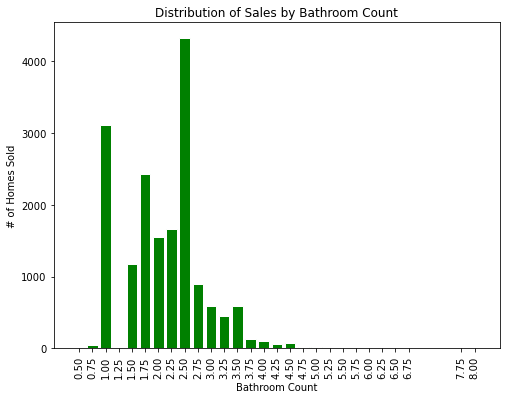

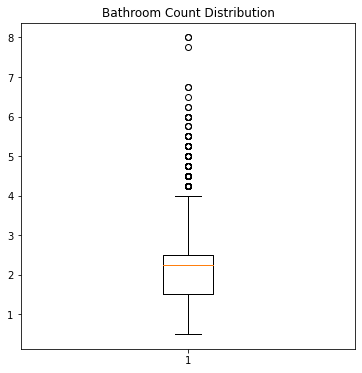

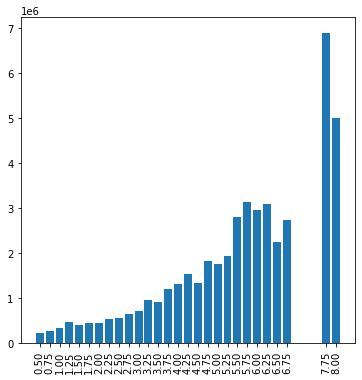

In [59]:
fig, ax = plt.subplots(figsize = (8,6))

plt.bar(df.bathrooms.value_counts().index, df.bathrooms.value_counts().values, width = 0.20, align='center', edgecolor='White', color = 'Green');
ax.set_xticks(list(set(df.bathrooms.value_counts().index)))
plt.xticks(rotation=90)
plt.title('Distribution of Sales by Bathroom Count')
plt.xlabel('Bathroom Count')
plt.ylabel('# of Homes Sold')
plt.savefig('Sales by Bathroom');

fig, ax = plt.subplots(figsize = (6,6))
ax.boxplot(df.bathrooms)
plt.title('Bathroom Count Distribution');

fig, ax = plt.subplots(figsize = (6,6))

x= df.groupby('bathrooms')['price'].mean().index
y= df.groupby('bathrooms')['price'].mean().values
ax.bar(x,y, width = .20)
ax.set_xticks(list(set(df.bathrooms.value_counts().index)))
plt.xticks(rotation=90);


### Bedrooms Graphs

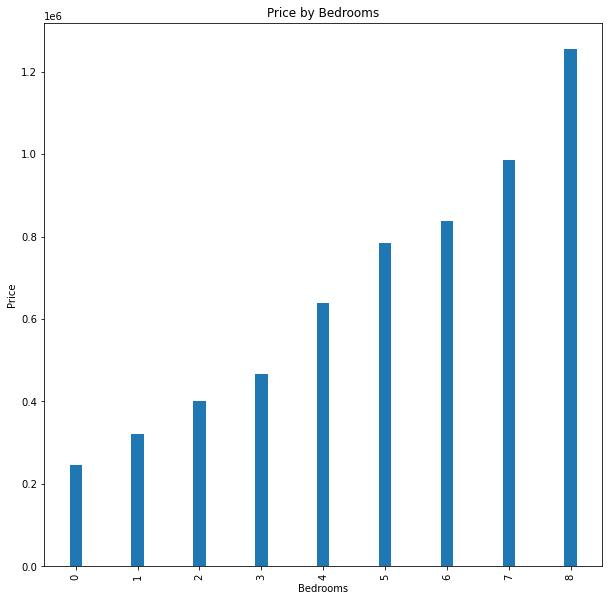

In [60]:
fig, ax = plt.subplots(figsize=(10,10))
x= df.groupby('bedrooms')['price'].mean().index
y= df.groupby('bedrooms')['price'].mean().values
ax.bar(x,y, width = .20)
ax.set_xticks(list(set(df.bedrooms.value_counts().index)))
plt.xticks(rotation=90)
ax.set_title('Price by Bedrooms')
ax.set_xlabel("Bedrooms")
ax.set_ylabel("Price");

## Season Graphs

<ipython-input-61-b270139b3851>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Winter", "Spring", "Summer", "Fall"])


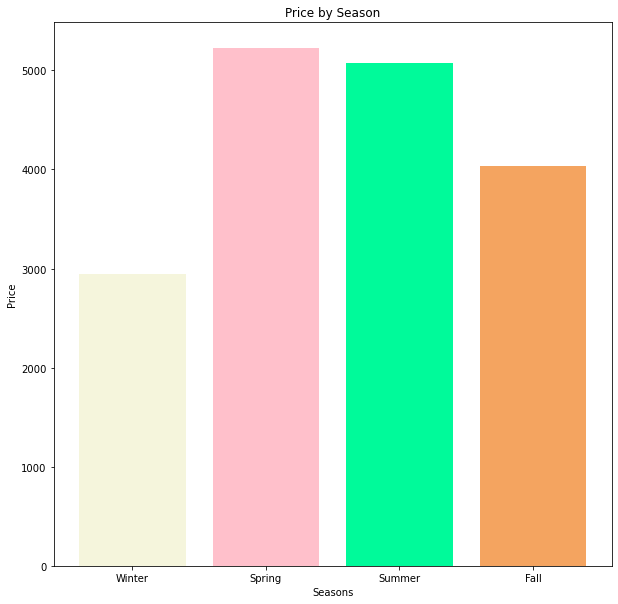

In [61]:
price_by_season

fig, ax = plt.subplots(figsize=(10,10))
ax.bar(price_by_season.index, price_by_season.values, color=['beige', 'pink', 'mediumspringgreen', 'sandybrown'])
ax.set_xticklabels(["Winter", "Spring", "Summer", "Fall"])
ax.set_xlabel('Seasons')
ax.set_ylabel('Price')
ax.set_title('Price by Season')
plt.savefig('price_by_season');

<ipython-input-62-b1ffb29d3ea3>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Winter", "Spring", "Summer", "Fall"])


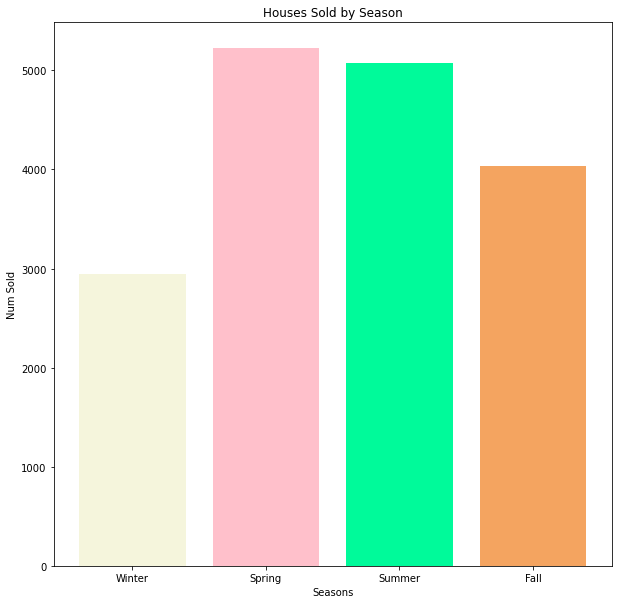

In [62]:
num_sold_by_seasons

fig, ax = plt.subplots(figsize=(10,10))
ax.bar(num_sold_by_seasons.index, num_sold_by_seasons.values, color=['beige', 'pink', 'mediumspringgreen', 'sandybrown'])
ax.set_xticklabels(["Winter", "Spring", "Summer", "Fall"])
ax.set_xlabel('Seasons')
ax.set_ylabel('Num Sold')
ax.set_title('Houses Sold by Season')
plt.savefig('sold_by_season');

# Fitting the Model

In [63]:
## add zipcode as dummy variable
subset=[
    "bathrooms",
    "bedrooms",
    "sqft_living", 
    "floors", 
    "waterfront", 
    "sqft_living15",
    "built_years",
    "renovated",
    "yard"
]

counter = 0

for zip in df.zipcode.values:
    if zip not in subset:
        subset.append(zip)
        counter += 1

In [64]:
for grade in set(df.grade.values):
    subset.append("grade_"+ str(grade))

In [65]:
for view in set(df.view.values):
    subset.append("view_"+ str(view))

In [66]:
for month in set(df.month_sold.values):
    subset.append("month_"+ str(month))

In [67]:
for condition in set(df.condition.values):
    subset.append("condition_"+ str(condition))

In [68]:
df[subset]

,bathrooms,bedrooms,sqft_living,floors,waterfront,sqft_living15,built_years,renovated,yard,98058,...,month_8,month_9,month_10,month_11,month_12,condition_1,condition_2,condition_3,condition_4,condition_5
0,2.25,4,2070,2.0,0,2390,35,0.0,8.592271,1,...,0,0,1,0,0,0,0,0,1,0
1,3.00,5,2900,1.0,0,2370,44,0.0,2.320690,0,...,1,0,0,0,0,0,0,0,0,1
2,2.50,4,3770,2.0,0,3710,24,0.0,5.778780,0,...,1,0,0,0,0,0,0,1,0,0
3,3.50,3,4560,2.0,0,4050,31,0.0,6.407018,0,...,0,0,0,0,0,0,0,1,0,0
4,2.50,3,2550,2.0,0,2250,17,0.0,4.216471,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,2.50,5,3240,1.0,0,2730,63,0.0,3.074074,0,...,0,0,0,0,0,0,0,1,0,0
17286,1.75,2,1300,2.0,0,1350,73,0.0,6.153846,0,...,0,0,0,0,0,0,0,1,0,0
17287,1.00,3,1050,1.0,0,1760,68,0.0,9.405714,0,...,0,0,0,0,0,0,0,1,0,0
17288,1.50,3,1900,1.5,0,2080,50,0.0,34.094211,0,...,0,0,0,0,1,0,0,0,1,0


In [69]:
lm = LinearRegression()

lm.fit(df[subset], df['price'])

LinearRegression()

In [70]:
print(lm.intercept_)
print(lm.coef_)

583748.3813216381
[ 2.13109385e+04 -1.25776981e+04  1.48091039e+02 -9.20002032e+03
  5.82554864e+05  2.12217742e+01  3.52916179e+02  5.29809635e+04
  3.74497902e+02 -1.60001826e+05  1.28008987e+05  4.52738957e+04
  5.66308720e+03  4.49862416e+04 -1.79503935e+05  5.78142902e+04
  1.77846261e+05 -3.69341150e+04  3.03299216e+05  1.37320504e+05
 -4.93912875e+04 -1.54066746e+05 -4.03486963e+04 -1.04566707e+05
 -1.09984144e+05  5.80402383e+05  1.89013210e+04 -3.66440485e+04
 -3.67523907e+04 -2.19895687e+05 -1.55150481e+04 -4.83707472e+02
 -9.50127117e+04 -7.94964072e+04 -2.02088967e+05  2.37796544e+04
  6.32294299e+04 -1.86344737e+05  2.89109010e+05  2.30353885e+04
 -1.85059307e+05 -1.94255302e+05 -9.85576605e+04 -1.05950263e+05
  8.25548362e+04 -1.62446009e+05  2.99903122e+05 -1.36248724e+05
 -2.38336216e+04 -1.95960150e+05 -1.91591486e+05  2.74880070e+05
 -2.23157583e+05 -6.57672555e+04  4.33535616e+05 -1.58697237e+05
  8.90819479e+04  1.40961845e+05 -1.69519547e+05 -1.47462941e+05
  9.667

In [71]:
y_pred=lm.predict(df[subset])

In [72]:
y_pred[:100]

array([ 350219.99031788,  823761.77369799, 1296186.21261374,
       1905536.60998577,  689478.92379255,  222035.13887676,
        745635.80684362,  690135.07082743,  372728.95943229,
        641064.44165118,  643768.89136764,  478114.71491267,
        211941.52719505,  401846.26914393,  258216.17635091,
       1158777.58504887,  922692.83982362, 1110874.08242904,
        331694.12319857,  458223.04727496,  359217.31299857,
       1291699.829092  ,  732404.07467026,  672429.32976043,
        557689.01064336,  457482.13243962,  214968.61092314,
        150607.31048875,  369071.60418384,  751323.03475204,
        423285.10059824,  581766.44981546,  547099.69797005,
        298680.9241761 ,  416777.50176527, 1005487.73461749,
        927034.2857554 ,  405051.66458512,  344256.0167159 ,
       1617124.38125805,  475184.85046098,  264419.59971143,
        346093.43538777,  311033.29284234,  212021.32259447,
        252700.36636126,  427833.71068156,  542528.63673446,
        419861.07497318,

Text(0, 0.5, 'Predicted Values')

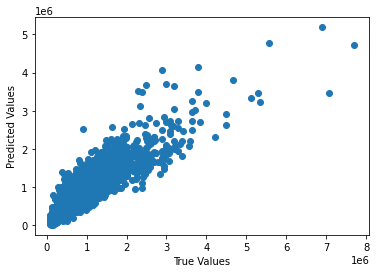

In [73]:
plt.scatter(df['price'], y_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

In [74]:
lm.score(df[subset], df['price'])

0.8356205672818129

In [75]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [76]:
mae = mean_absolute_error(df['price'], y_pred)
mse = mean_squared_error(df['price'], y_pred)
rmse = np.sqrt(mse)

In [77]:
rmse

151344.19253506578

## Plotting the residuals

C:\Users\dlee0\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='price'>

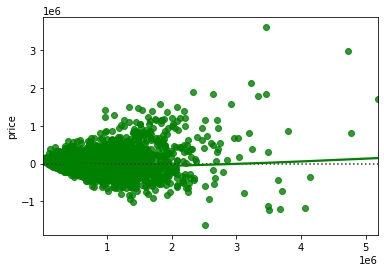

In [78]:
sns.residplot(y_pred, df['price'], lowess=True, color = "g")

In [79]:
residuals = df['price']-y_pred

C:\Users\dlee0\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\dlee0\anaconda3\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


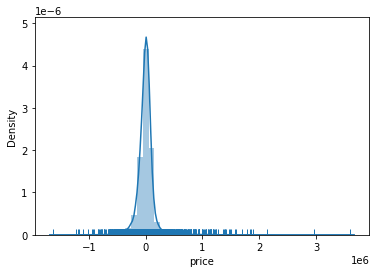

In [80]:
sns.distplot(residuals, kde=True, rug=True);

In [81]:
import statsmodels.api as sm

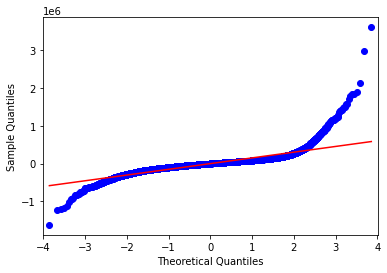

In [82]:
fig = sm.qqplot(residuals, line = 's')
plt.show()

In [83]:
df['log_price'] = np.log(df['price'])

In [84]:
np.exp(df['log_price'])

0         365000.0
1         865000.0
2        1038000.0
3        1490000.0
4         711000.0
           ...    
17285     750000.0
17286     440000.0
17287     310000.0
17288     427500.0
17289     348000.0
Name: log_price, Length: 17267, dtype: float64

array([[<AxesSubplot:title={'center':'log_price'}>]], dtype=object)

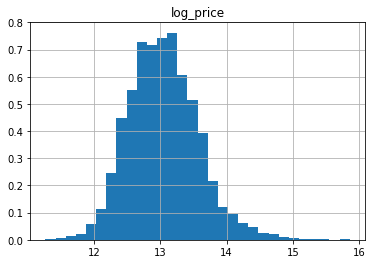

In [85]:
df.hist(column=['log_price'], bins=30, density=True)

In [86]:
lm_log = LinearRegression()
lm_log.fit(df[subset], df['log_price'])

LinearRegression()

In [87]:
y_log_pred = lm_log.predict(df[subset])

C:\Users\dlee0\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='log_price'>

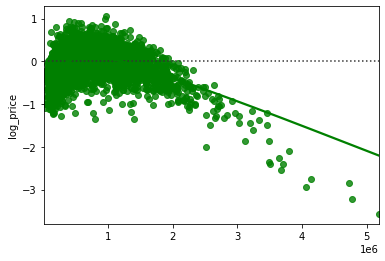

In [88]:
sns.residplot(y_pred, df['log_price'], lowess=True, color = "g")

In [89]:
subset

['bathrooms',
 'bedrooms',
 'sqft_living',
 'floors',
 'waterfront',
 'sqft_living15',
 'built_years',
 'renovated',
 'yard',
 98058,
 98115,
 98006,
 98034,
 98052,
 98031,
 98007,
 98199,
 98027,
 98119,
 98122,
 98155,
 98055,
 98118,
 98014,
 98059,
 98004,
 98053,
 98072,
 98133,
 98092,
 98074,
 98125,
 98045,
 98106,
 98022,
 98177,
 98008,
 98002,
 98040,
 98029,
 98042,
 98001,
 98065,
 98056,
 98144,
 98188,
 98109,
 98010,
 98075,
 98198,
 98030,
 98105,
 98023,
 98028,
 98112,
 98038,
 98116,
 98103,
 98178,
 98168,
 98005,
 98077,
 98146,
 98011,
 98126,
 98108,
 98136,
 98033,
 98003,
 98117,
 98107,
 98019,
 98102,
 98032,
 98148,
 98166,
 98070,
 98024,
 98039,
 'grade_3',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13',
 'view_0',
 'view_1',
 'view_2',
 'view_3',
 'view_4',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 '

In [90]:
df['sqftliving_log'] = np.log(df['sqft_living'])
df['sqftliving15_log'] = np.log(df['sqft_living15'])

In [91]:
subset[5] = 'sqftliving15_log'
subset[2] = 'sqftliving_log'

In [92]:
subset

['bathrooms',
 'bedrooms',
 'sqftliving_log',
 'floors',
 'waterfront',
 'sqftliving15_log',
 'built_years',
 'renovated',
 'yard',
 98058,
 98115,
 98006,
 98034,
 98052,
 98031,
 98007,
 98199,
 98027,
 98119,
 98122,
 98155,
 98055,
 98118,
 98014,
 98059,
 98004,
 98053,
 98072,
 98133,
 98092,
 98074,
 98125,
 98045,
 98106,
 98022,
 98177,
 98008,
 98002,
 98040,
 98029,
 98042,
 98001,
 98065,
 98056,
 98144,
 98188,
 98109,
 98010,
 98075,
 98198,
 98030,
 98105,
 98023,
 98028,
 98112,
 98038,
 98116,
 98103,
 98178,
 98168,
 98005,
 98077,
 98146,
 98011,
 98126,
 98108,
 98136,
 98033,
 98003,
 98117,
 98107,
 98019,
 98102,
 98032,
 98148,
 98166,
 98070,
 98024,
 98039,
 'grade_3',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13',
 'view_0',
 'view_1',
 'view_2',
 'view_3',
 'view_4',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_1

In [93]:
lm_log = LinearRegression()
lm_log.fit(df[subset], df['log_price'])

LinearRegression()

In [94]:
y_log_pred = lm_log.predict(df[subset])

C:\Users\dlee0\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='log_price'>

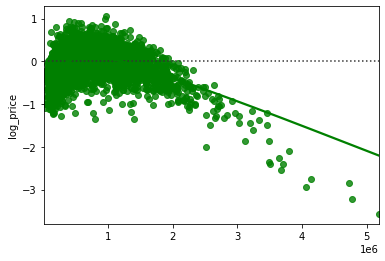

In [95]:
sns.residplot(y_pred, df['log_price'], lowess=True, color = "g")

In [96]:
log_residuals = df['log_price']-y_log_pred 

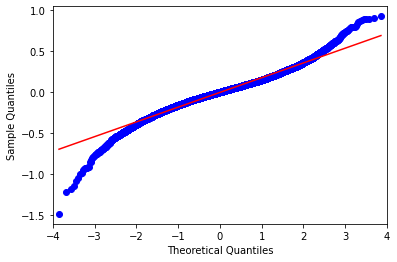

In [97]:
fig = sm.qqplot(log_residuals, line = 's')
plt.show()

## Feature Selection

In [98]:
df_features = df[subset]

target = df['price']

In [99]:
pd.set_option('display.max_rows', 1000)
df_features.columns

Index([       'bathrooms',         'bedrooms',   'sqftliving_log',
                 'floors',       'waterfront', 'sqftliving15_log',
            'built_years',        'renovated',             'yard',
                    98058,
       ...
                'month_8',          'month_9',         'month_10',
               'month_11',         'month_12',      'condition_1',
            'condition_2',      'condition_3',      'condition_4',
            'condition_5'],
      dtype='object', length=112)

In [100]:
pd.set_option('display.max_rows', 1000)
df_features.isnull().mean()

bathrooms           0.0
bedrooms            0.0
sqftliving_log      0.0
floors              0.0
waterfront          0.0
sqftliving15_log    0.0
built_years         0.0
renovated           0.0
yard                0.0
98058               0.0
98115               0.0
98006               0.0
98034               0.0
98052               0.0
98031               0.0
98007               0.0
98199               0.0
98027               0.0
98119               0.0
98122               0.0
98155               0.0
98055               0.0
98118               0.0
98014               0.0
98059               0.0
98004               0.0
98053               0.0
98072               0.0
98133               0.0
98092               0.0
98074               0.0
98125               0.0
98045               0.0
98106               0.0
98022               0.0
98177               0.0
98008               0.0
98002               0.0
98040               0.0
98029               0.0
98042               0.0
98001           

In [101]:
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=42, test_size = 0.2)

In [102]:
lm = LinearRegression()

lm = lm.fit(X_train, y_train)

y_train_pred = lm.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('Training RMSE', train_rmse)

Training RMSE 157980.79576078142


In [103]:
#use fitted model to predict on the test examples
y_test_pred = lm.predict(X_test)

#evaluate the predictions on the test examples
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print('Testing RMSE:' , test_rmse)


print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Testing RMSE: 158753.15184383694
Training:  157980 vs. Testing:  158753


C:\Users\dlee0\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

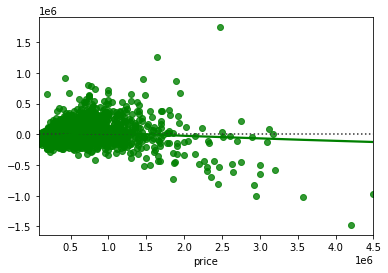

In [104]:
sns.residplot(y_test, y_test_pred, lowess=True, color="g")

## Use the new model to predict the test set.

In [105]:
y_test_pred = lm_log.predict(X_test)


#our model predcicte the log of gross, so now we must exponentiate to get the value in $
y_test_pred = np.exp(y_test_pred)

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print('Testing Root Mean Squared Error:' , test_rmse)


print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Testing Root Mean Squared Error: 134537.02574549543
Training:  157980 vs. Testing:  134537


### Process

In [128]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_features, target, random_state=9,test_size=0.2)


In [129]:
# Create correlation matrix
corr_matrix = X_train_2.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,bathrooms,bedrooms,sqftliving_log,floors,waterfront,sqftliving15_log,built_years,renovated,yard,98058,...,month_8,month_9,month_10,month_11,month_12,condition_1,condition_2,condition_3,condition_4,condition_5
bathrooms,NaN,0.523885,0.763349,0.499571,0.069225,0.566927,0.510844,0.048583,0.005029,0.002799,...,0.001704,0.010213,0.009385,0.005827,0.000969,0.045863,0.068715,0.185398,0.164425,0.030714
bedrooms,NaN,NaN,0.639521,0.183856,0.004915,0.420835,0.172268,0.007249,0.033532,0.029291,...,0.007276,0.003005,0.003377,0.001503,0.007035,0.030573,0.043751,0.007364,0.006680,0.016431
sqftliving_log,NaN,NaN,NaN,0.371400,0.087405,0.743322,0.355199,0.043569,0.031314,0.002147,...,0.004090,0.003284,0.003087,0.001931,0.002177,0.043679,0.076228,0.095563,0.074732,0.015862
floors,NaN,NaN,NaN,NaN,0.027213,0.275328,0.484210,0.007089,0.028000,0.028735,...,0.000009,0.005720,0.018183,0.004308,0.005162,0.022832,0.059651,0.315458,0.252012,0.123454
waterfront,NaN,NaN,NaN,NaN,NaN,0.090272,0.023781,0.096157,0.008666,0.013592,...,0.006212,0.009345,0.005853,0.013743,0.003778,0.018205,0.000675,0.012961,0.003696,0.014064
sqftliving15_log,NaN,NaN,NaN,NaN,NaN,NaN,0.338641,0.009951,0.068940,0.000142,...,0.012320,0.002056,0.004579,0.013252,0.007629,0.010058,0.045263,0.107549,0.071847,0.056306
built_years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.227459,0.031893,0.036784,...,0.007463,0.007771,0.006508,0.003423,0.005438,0.053158,0.060259,0.389391,0.257702,0.239603
renovated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005455,0.000781,...,0.006728,0.006593,0.020530,0.003723,0.009965,0.007798,0.010973,0.070937,0.051094,0.037207
yard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021096,...,0.002216,0.000084,0.006420,0.007530,0.005865,0.012601,0.078094,0.004676,0.013517,0.013780
98058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.013715,0.014328,0.014349,0.002459,0.004826,0.007871,0.003143,0.017724,0.017082,0.001389


<AxesSubplot:>

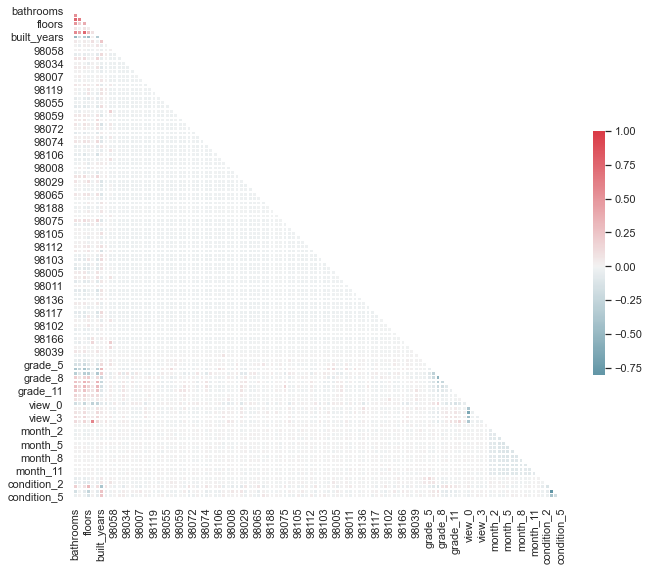

In [130]:
sns.set(style="white")


# Compute the correlation matrix
corr = X_train_2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [131]:
# Find index of feature columns with correlation greater than 0.80
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

#if you change inplace to True it will go through and drop all of those columns from the dataset
X_train_2.drop(columns=to_drop, inplace=False)
X_test_2.drop(columns=to_drop, inplace=False)


,bathrooms,bedrooms,sqftliving_log,floors,waterfront,sqftliving15_log,built_years,renovated,yard,98058,...,month_7,month_8,month_9,month_10,month_11,month_12,condition_1,condition_2,condition_3,condition_5
14101,2.00,6,7.467371,1.0,0,7.467371,78,0.0,10.105714,0,...,0,0,0,0,0,0,0,0,0,0
13734,2.50,3,7.787382,2.0,0,7.787382,12,0.0,3.863900,0,...,0,0,1,0,0,0,0,0,1,0
4846,1.00,3,6.802395,1.0,0,6.907755,62,0.0,9.000000,0,...,0,0,0,0,0,0,0,0,0,0
4669,1.00,3,7.185387,1.5,0,6.917706,108,0.0,6.534091,0,...,1,0,0,0,0,0,0,0,1,0
4090,2.00,5,7.723120,1.0,0,7.575585,59,0.0,5.296460,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6681,1.50,3,7.251345,1.0,0,7.554859,68,0.0,6.382979,0,...,0,0,0,1,0,0,0,0,1,0
7262,1.75,3,6.984716,1.0,0,7.484369,95,0.0,2.962963,0,...,0,0,0,0,0,0,0,0,0,0
5993,1.00,3,6.756932,1.5,0,7.130899,94,0.0,11.127907,0,...,0,0,0,1,0,0,0,0,0,0
2975,2.00,3,7.358831,1.0,0,7.358831,23,0.0,3.343949,0,...,0,0,0,0,0,0,0,0,1,0


In [132]:
to_drop

['condition_4']

## Use the new model to predict the test set.

In [133]:
subset2=[
    "bathrooms",
    "bedrooms",
    "sqft_living", 
    "floors", 
    "waterfront", 
    "sqft_living15",
    "built_years",
    "renovated",
    "yard"
]

counter = 0

for zip in df.zipcode.values:
    if zip not in subset:
        subset2.append(zip)
        counter += 1

In [134]:
for grade in set(df.grade.values):
    subset2.append("grade_"+ str(grade))

In [135]:
for view in set(df.view.values):
    subset2.append("view_"+ str(view))

In [136]:
for month in set(df.month_sold.values):
    subset2.append("month_"+ str(month))

In [137]:
for condition in set(df.condition.values):
    if condition != 4:
        subset2.append("condition_"+ str(condition))

In [138]:
df_features_2 = df[subset2]

target = df['price']

In [139]:
X_train, X_test, y_train, y_test = train_test_split(df_features_2, target, random_state=42, test_size = 0.2)

In [140]:
lm = LinearRegression()

lm = lm.fit(X_train, y_train)

y_train_pred = lm.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('Training RMSE', train_rmse)

Training RMSE 207820.01528007325


In [141]:
#use fitted model to predict on the test examples
y_test_pred = lm.predict(X_test)

#evaluate the predictions on the test examples
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print('Testing RMSE:' , test_rmse)


print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

Testing RMSE: 211324.2110963911
Training:  207820 vs. Testing:  211324


C:\Users\dlee0\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

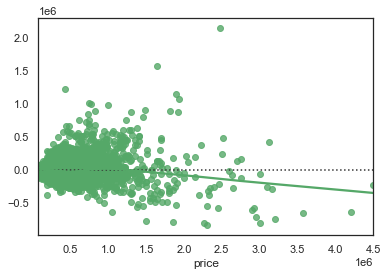

In [120]:
sns.residplot(y_test, y_test_pred, lowess=True, color="g")

In [121]:
y_test_pred = lm_log.predict(X_test)


#our model predcicte the log of gross, so now we must exponentiate to get the value in $
y_test_pred = np.exp(y_test_pred)

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print('Testing Root Mean Squared Error:' , test_rmse)


print('Training: ', int(train_rmse), "vs. Testing: ", int(test_rmse))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 112 is different from 41)

### F Test

In [142]:
X_train


,bathrooms,bedrooms,sqft_living,floors,waterfront,sqft_living15,built_years,renovated,yard,grade_3,...,month_7,month_8,month_9,month_10,month_11,month_12,condition_1,condition_2,condition_3,condition_5
3320,2.50,3,1820,1.5,0,1480,95,1.0,7.188462,0,...,0,0,0,0,0,0,0,0,1,0
8660,2.25,3,2180,1.0,0,1740,48,0.0,3.142202,0,...,1,0,0,0,0,0,0,0,1,0
10770,2.50,3,2430,2.0,0,2380,12,0.0,4.827984,0,...,0,0,0,0,0,0,0,0,1,0
7216,1.00,2,1040,1.0,0,1930,82,0.0,7.088462,0,...,0,0,0,0,0,0,0,0,0,1
13405,2.00,3,1610,2.0,0,2410,88,1.0,17.448447,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11302,2.00,3,1600,1.0,0,1800,69,0.0,6.023750,0,...,0,0,0,0,0,0,0,0,0,1
11982,2.50,3,1710,2.0,0,2120,22,0.0,4.057310,0,...,1,0,0,0,0,0,0,0,1,0
5397,1.50,4,1600,2.0,0,1690,119,0.0,7.187500,0,...,0,0,0,0,0,0,0,0,0,0
861,1.75,2,1894,1.5,0,1820,85,0.0,41.791711,0,...,0,1,0,0,0,0,0,0,0,0


In [124]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

selector = SelectKBest(f_regression, k=30)

selector.fit(X_train, y_train)

SelectKBest(k=30, score_func=<function f_regression at 0x000001C39D633B80>)

In [125]:
selector.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True, False, False, False, False, False,
       False,  True,  True, False,  True])

In [126]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]
# X_train = X_train[selected_columns]
# X_test = X_test[selected_columns]

In [ ]:
list(removed_columns)

In [ ]:
list(selected_columns)

In [ ]:
#instantiate a linear regression object
lm_kbest = LinearRegression()

#fit the linear regression to the data
lm_kbest.fit(X_train[selected_columns], y_train)

y_train_kbest = lm_kbest.predict(X_train[selected_columns])


trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))


print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = lm_kbest.predict(X_test[selected_columns])

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))

print('Testing Root Mean Squared Error:' , testK_rmse)




### RFECV

In [ ]:
from sklearn.feature_selection import RFECV

In [ ]:
ols = LinearRegression()

In [ ]:
ols = LinearRegression()
# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=ols, step=1, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Fit recursive feature eliminator 
selector.fit(X_train, y_train)



In [ ]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]


In [ ]:
list(removed_rfe)

In [ ]:
len(list(selected_rfe))

In [ ]:
selected_rfe

Now let's use those selected features to fit a model.

In [ ]:
#instantiate a linear regression object
lm_rfe = LinearRegression()

#fit the linear regression to the data
lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

y_rfe = lm_rfe.predict(X_train[selected_rfe])


trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))


print('Training Root Mean Squared Error:' , trainRFE_rmse)

y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])

testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))

print('Testing Root Mean Squared Error:' , testRFE_rmse)




In [ ]:
print('Original: ', test_rmse, '\n',
      "KBest:   ", testK_rmse,'\n',
      "RFE:     ", testRFE_rmse)